# Calculations to design the questionnaire

In [2]:
import numpy as np
from scipy import stats
from scipy import special
import matplotlib.pyplot as plt
import math

### Geometry

In [3]:
total_height = 9
crest_legth = 4
slope = 3
angle_slope = math.atan(1/3)
slope_length = 9/math.sin(angle_slope)
dike_base_slope = total_height/math.tan(angle_slope)
total_base = crest_legth + 2*dike_base_slope
print("Total base width: ", total_base)

Total base width:  57.99999999999999


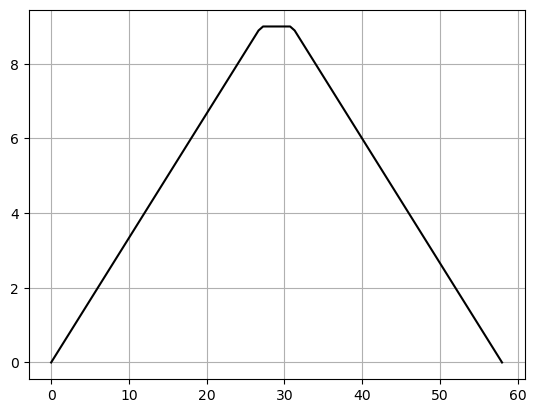

In [4]:
# more precise dike profile

length_arrays = 101
coord_x = np.linspace(0, total_base, length_arrays)

coord_y_dike = np.empty(length_arrays)
for i in range(length_arrays):
    if coord_x[i] < dike_base_slope:
        coord_y_dike[i] = coord_x[i]/slope
    elif coord_x[i] >= dike_base_slope and coord_x[i] <= (dike_base_slope + crest_legth):
        coord_y_dike[i] = total_height
    else:
        coord_y_dike[i] = -(coord_x[i] - (dike_base_slope + crest_legth))/slope + total_height

plt.plot(coord_x, coord_y_dike, color='black')
plt.grid()

### Dupuit parabola - Darcy approx solution: homogeneous dike

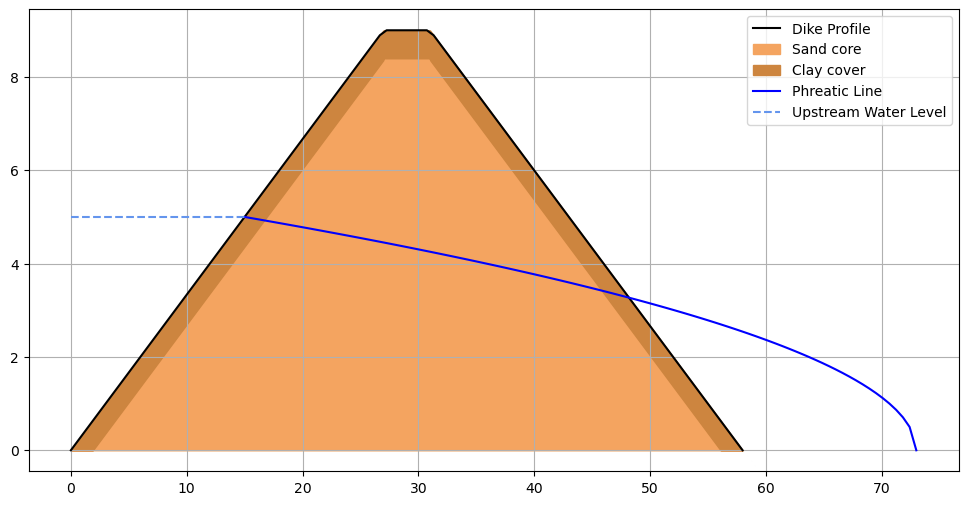

In [31]:
hydraulic_head_up = 5
hydraulic_head_down = 0

# look for the intersection between the water level and the slope
x_entrance_water = slope * hydraulic_head_up

# phreatic levels
phreatic_levels = np.sqrt(hydraulic_head_up**2 - (hydraulic_head_up**2 - hydraulic_head_down**2) * ((coord_x) / total_base))

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(coord_x, coord_y_dike, color='black', label='Dike Profile')
# sand: fill from base (0) up to top of sand
plt.fill_between(x, 0.0, z_sand_top, color='sandybrown', label='Sand core')
# clay: fill from top of sand up to surface
plt.fill_between(x, z_sand_top, z_top, color='peru', label='Clay cover')
ax.plot(coord_x + x_entrance_water, phreatic_levels, color='blue', label='Phreatic Line')
ax.plot([0, 15], [hydraulic_head_up, hydraulic_head_up], color='cornflowerblue', linestyle='--', label='Upstream Water Level')
ax.grid()
ax.legend()

Crossing point (x, y):  48.13999999999999 3.2787192621510006


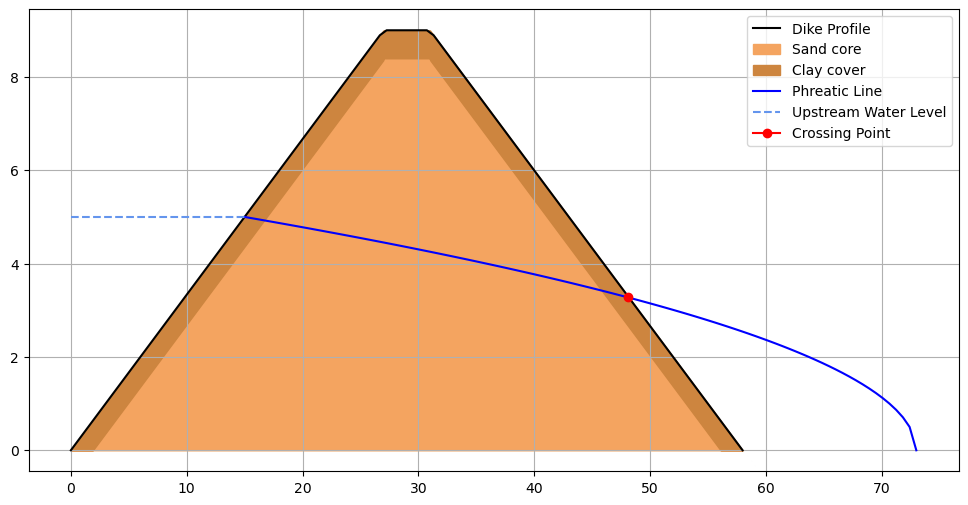

In [30]:
# Find crossing point between phreatic line and dike profile downstream

indices = np.where(coord_x > x_entrance_water)[0]
if indices.size > 0:
    first_index = indices[0]
    # print(first_index, coord_x[first_index]) 
else:
    print("No element greater than threshold.")


for i in range(first_index, length_arrays):
    if coord_y_dike[i] > phreatic_levels[i-first_index]:
        crossing_point_x = coord_x[i]
        crossing_point_y = phreatic_levels[i-first_index]
print("Crossing point (x, y): ", crossing_point_x, crossing_point_y)

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(coord_x, coord_y_dike, color='black', label='Dike Profile')
# sand: fill from base (0) up to top of sand
plt.fill_between(x, 0.0, z_sand_top, color='sandybrown', label='Sand core')
# clay: fill from top of sand up to surface
plt.fill_between(x, z_sand_top, z_top, color='peru', label='Clay cover')
ax.plot(coord_x + x_entrance_water, phreatic_levels, color='blue', label='Phreatic Line')
ax.plot([0, 15], [hydraulic_head_up, hydraulic_head_up], color='cornflowerblue', linestyle='--', label='Upstream Water Level')
ax.grid()
ax.legend()
ax.plot(crossing_point_x, crossing_point_y, marker='o', color='red', label='Crossing Point')
ax.legend()

### Two layer section - to revise

Computed steady discharge per unit width q = 2.231e-07 m²/s
Water enters at x = 15.00 m


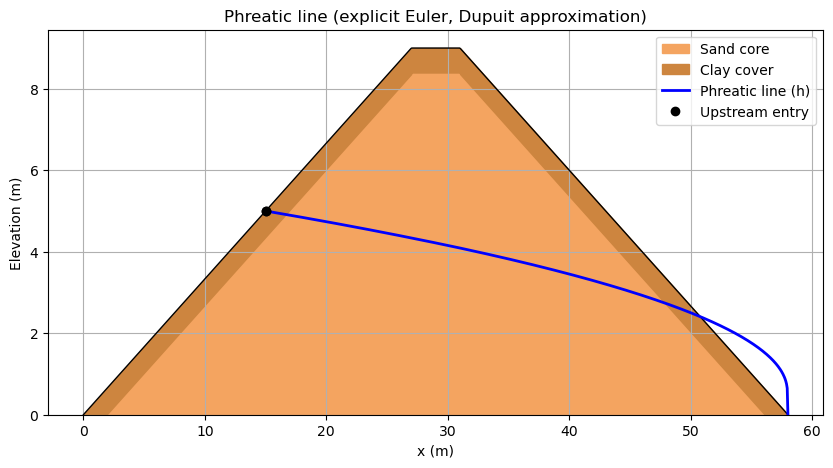

In [37]:
import numpy as np
import math
import matplotlib.pyplot as plt

def phreatic_two_material_slope(
    K_clay, K_sand, d_clay_top,
    H_up, H_down, L, H_dike, m,
    N=1001
):
    """
    Compute steady-state phreatic line for a symmetric trapezoidal dike with
    a clay top layer and sand core using the Dupuit approximation.

    Returns:
        x, z_top, h, q, x_entry
    """
    # --- Mesh and geometry ---
    x = np.linspace(0.0, L, N)
    dx = x[1] - x[0]

    x_up = m * H_dike
    x_down = L - m * H_dike
    angle_slope = math.atan(1.0 / m)

    # Dike surface (z_top)
    z_top = np.piecewise(
        x,
        [x <= x_up, (x > x_up) & (x < x_down), x >= x_down],
        [
            lambda xx: (xx / x_up) * H_dike if x_up > 0 else H_dike,
            lambda xx: H_dike,
            lambda xx: H_dike - ((xx - x_down) / (L - x_down)) * H_dike if (L - x_down) > 0 else 0.0
        ]
    )

    # --- Find intersection of upstream head with surface ---
    i_cross = np.argmax(z_top >= H_up)
    if i_cross == 0:
        x_entry = x[0]
    else:
        x0, x1 = x[i_cross-1], x[i_cross]
        z0, z1 = z_top[i_cross-1], z_top[i_cross]
        frac = (H_up - z0) / (z1 - z0) if (z1 != z0) else 0.0
        x_entry = x0 + frac * (x1 - x0)

    # Active domain (from entry to downstream toe)
    x_active = x[x >= x_entry]
    dx = x_active[1] - x_active[0]

    # --- Local transmissivity function ---
    def transmissivity(h_val, z_local, x_local):
        """Return scalar transmissivity T = K_clay*top_sat + K_sand*bottom_sat"""
        h = float(h_val)
        z = float(z_local)
        xl = float(x_local)

        # local clay thickness
        if (xl <= x_up) or (xl >= x_down):
            clay_thickness = d_clay_top / math.cos(angle_slope)
        else:
            clay_thickness = d_clay_top

        z_sand_top = z - clay_thickness

        # clay saturation thickness
        if h > z_sand_top:
            top_sat = min(clay_thickness, h - z_sand_top)
        else:
            top_sat = 0.0

        # sand saturation thickness
        bottom_sat = max(h - clay_thickness, 0.0)

        return K_clay * top_sat + K_sand * bottom_sat

    # --- Integrator for given q ---
    def integrate(q):
        h = np.empty_like(x_active)
        h[0] = H_up
        for i in range(len(x_active) - 1):
            xi = x_active[i]
            Ti = transmissivity(h[i], np.interp(xi, x, z_top), xi)
            if Ti <= 0 or h[i] <= 0:
                return None
            dhdx = -q / Ti  # Correct Dupuit form (no division by h!)
            h[i+1] = h[i] + dhdx * dx
            if h[i+1] <= 0:
                return None
        return h

    # --- Shooting method for q ---
    active_length = x_active[-1] - x_active[0]
    K_est = max(K_clay, K_sand)
    q_est = (K_est / (2.0 * active_length)) * (H_up**2 - H_down**2)

    q_lo = 0.0
    q_hi = max(1e-20, 10 * q_est)
    h_lo = integrate(q_lo)
    h_lo_end = h_lo[-1] if h_lo is not None else -np.inf

    for _ in range(60):
        h_hi = integrate(q_hi)
        h_hi_end = h_hi[-1] if h_hi is not None else -np.inf
        if (h_lo_end > H_down) and (h_hi_end <= H_down):
            break
        q_hi *= 2.0
    else:
        raise RuntimeError("Could not bracket q.")

    # Bisection for q
    for _ in range(100):
        q_mid = 0.5 * (q_lo + q_hi)
        h_mid = integrate(q_mid)
        if h_mid is None:
            q_hi = q_mid
            continue
        err = h_mid[-1] - H_down
        if abs(err) < 1e-6:
            break
        if err > 0:
            q_lo = q_mid
        else:
            q_hi = q_mid
    else:
        raise RuntimeError("Did not converge for q.")

    return x, z_top, np.interp(x, x_active, h_mid, left=np.nan, right=np.nan), q_mid, x_entry


# ---------------- Example Run ----------------
K_clay = 1e-9
K_sand = 1e-6
d_clay_top = 0.6
H_up = hydraulic_head_up
H_down = hydraulic_head_down
L = total_base
H_dike = total_height
m = slope

x, z_top, h, q, x_entry = phreatic_two_material_slope(
    K_clay, K_sand, d_clay_top, H_up, H_down, L, H_dike, m
)

print(f"Computed steady discharge per unit width q = {q:.3e} m²/s")
print(f"Water enters at x = {x_entry:.2f} m")

# --- Plot ---
angle_slope = math.atan(1.0 / m)
d_clay_local = np.where(
    (x <= m * H_dike) | (x >= (L - m * H_dike)),
    d_clay_top / math.cos(angle_slope),
    d_clay_top
)
z_sand_top = np.maximum(z_top - d_clay_local, 0.0)

plt.figure(figsize=(10, 5))
plt.fill_between(x, 0.0, z_sand_top, color="sandybrown", label="Sand core")
plt.fill_between(x, z_sand_top, z_top, color="peru", label="Clay cover")
plt.plot(x, z_top, "k-", lw=1)
plt.plot(x, h, "b-", lw=2, label="Phreatic line (h)")
plt.plot([x_entry,x_entry], [x_entry/m,x_entry/m], 'ok', label="Upstream entry")
plt.xlabel("x (m)")
plt.ylabel("Elevation (m)")
plt.title("Phreatic line (explicit Euler, Dupuit approximation)")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()


End of notebook.